In [48]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import glob
import pickle
import random
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.metrics import classification_report, accuracy_score
from utils import extract_features_many_filenames, read_img, get_hog_features, CONVERT_RGB_TO

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [62]:
# To save as normal python script (easier to git diff)
!jupyter nbconvert --to script classifier.ipynb

[NbConvertApp] Converting notebook classifier.ipynb to script
[NbConvertApp] Writing 5129 bytes to classifier.py


In [17]:
training_folders = {
    'vehicles': [
        'KITTI_extracted',
        'GTI_Right',
        'GTI_MiddleClose',
        'GTI_Left',
        'GTI_Far'
    ],
    'non-vehicles': [
        'GTI',
        'Extras'
    ]
}

training_filenames = {
    'vehicles': [],
    'non-vehicles': []
}

for folder, subfolders in training_folders.items():
    for subfolder in subfolders:
        files = glob.glob(folder + '/' + subfolder + '/' + '*.png')
        training_filenames[folder].extend(files)

In [18]:
# PARAMETERS
config = {
    'color_space': 'YUV',      # Can be RGB, HSV, LUV, HLS, YUV, YCrCb

    'spatial_feat': True,      # Spatial features on or off
    'hist_feat': True,         # Histogram features on or off
    'hog_feat': True,          # HOG features on or off
    
    # HOG features
    'orient': 11,               # HOG orientations
    'pix_per_cell': 8,         # HOG pixels per cell
    'cell_per_block': 2,       # HOG cells per block
    'hog_channel': 'ALL',      # Can be 0, 1, 2, or "ALL"

    # Spatial features
    'spatial_size': (16, 16),  # Spatial binning dimensions

    # Color hist features
    'hist_bins': 32,           # Number of histogram bins (for color histogram feature)
    'hist_range': (0, 256)     # Range for color histogram
}

/Users/robertmoss/Code/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


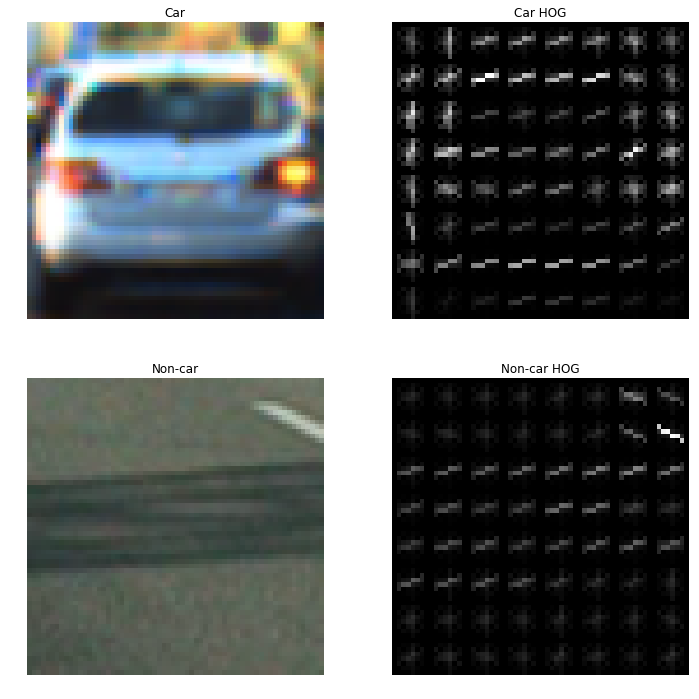

In [61]:
# Visualise the HOG, spatial and colour features
# For a car and non-car image
car_img = read_img(random.choice(training_filenames['vehicles']), 'cv2')
noncar_img = read_img(random.choice(training_filenames['non-vehicles']), 'cv2')

car_img_cvt = cv2.cvtColor(car_img, CONVERT_RGB_TO[config['color_space']])
noncar_img_cvt = cv2.cvtColor(noncar_img, CONVERT_RGB_TO[config['color_space']])

car_hog_img = []
noncar_hog_img = []
for c in range(car_img.shape[2]):
    _, hog_img = get_hog_features(car_img_cvt[:,:,c], config['orient'], config['pix_per_cell'], config['cell_per_block'], vis=True, feature_vec=True)
    car_hog_img.append(hog_img)
    _, hog_img = get_hog_features(noncar_img_cvt[:,:,c], config['orient'], config['pix_per_cell'], config['cell_per_block'], vis=True, feature_vec=True)
    noncar_hog_img.append(hog_img)

car_hog_img = np.moveaxis(np.asarray(car_hog_img), 0, -1)
car_hog_img = np.sum(car_hog_img, axis=2)
noncar_hog_img = np.moveaxis(np.asarray(noncar_hog_img), 0, -1)
noncar_hog_img = np.sum(noncar_hog_img, axis=2)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

ax1.imshow(car_img)
ax1.set_title('Car')
ax1.axis('off')
ax2.imshow(car_hog_img, cmap='gray')
ax2.set_title('Car HOG')
ax2.axis('off')
ax3.imshow(noncar_img, cmap='gray')
ax3.set_title('Non-car')
ax3.axis('off')
ax4.imshow(noncar_hog_img, cmap='gray')
ax4.set_title('Non-car HOG')
ax4.axis('off')
# plt.savefig("output_images/hogs.jpg", bbox_inches='tight')

In [5]:
%%time
# Feature extraction and preparation
car_features = extract_features_many_filenames(training_filenames['vehicles'], **config)
notcar_features = extract_features_many_filenames(training_filenames['non-vehicles'], **config)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2)

print('Feature vector length:', len(X_train[0]))

/Users/robertmoss/Code/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Feature vector length: 7332
CPU times: user 3min, sys: 12.9 s, total: 3min 13s
Wall time: 5min 55s


In [6]:
%%time
# Create the classifier
svc = LinearSVC()

# Train the classifier
svc.fit(X_train, y_train)

CPU times: user 17.6 s, sys: 9.18 s, total: 26.7 s
Wall time: 36.7 s


In [7]:
# Classifier accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
pred = svc.predict(X_test)
acc = accuracy_score(y_test, pred)
print(classification_report(y_test, pred, target_names=['non-cars', 'cars'], digits=4))

Test Accuracy of SVC =  0.9947
             precision    recall  f1-score   support

   non-cars     0.9944    0.9950    0.9947      1787
       cars     0.9949    0.9943    0.9946      1765

avg / total     0.9947    0.9947    0.9947      3552



In [8]:
# Save the classifier (and the config for training so feature preparation
# is the same for training and prediction when classifier is loaded)
pickle.dump(svc, open('svc_classifier.pkl', 'wb'))
pickle.dump(config, open('feature_config.pkl', 'wb'))
pickle.dump(X_scaler, open('x_scaler.pkl', 'wb'))